In [ ]:
!nvidia-smi

Thu Nov 27 13:29:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   67C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [ ]:
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q
!python setup.py build_ext --inplace

Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 41.16 MiB/s, done.
Resolving deltas: 100% (381/381), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.2 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done
running build_ext
W1127 13:36:04.678000 1886 torch/utils/cpp_extension.py:630] Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
W1127 13:36:04.723000 1886 torch

In [ ]:
!pip install -q supervision[assets] jupyter_bbox_widget

In [ ]:
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_tiny.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_small.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_base_plus.pt -P {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

In [ ]:
import cv2
import torch
import base64

import numpy as np
import supervision as sv

from pathlib import Path
from supervision.assets import download_assets, VideoAssets
from sam2.build_sam import build_sam2_video_predictor

IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

In [ ]:
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = f"{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"

sam2_model = build_sam2_video_predictor(CONFIG, CHECKPOINT)

In [ ]:
SOURCE_VIDEO = "/content/aphids.mp4"
sv.VideoInfo.from_video_path(SOURCE_VIDEO)

VideoInfo(width=1920, height=1080, fps=30, total_frames=278)

In [ ]:
SCALE_FACTOR = 0.5
START_IDX = 100
END_IDX = 300

In [ ]:
SOURCE_FRAMES = Path(HOME) / Path(SOURCE_VIDEO).stem
SOURCE_FRAMES.mkdir(parents=True, exist_ok=True)

# Get the total frames from the video info
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
total_frames = video_info.total_frames

# Adjust END_IDX if it exceeds the total_frames
adjusted_end_idx = min(END_IDX, total_frames)

frames_generator = sv.get_video_frames_generator(SOURCE_VIDEO, start=START_IDX, end=adjusted_end_idx)
images_sink = sv.ImageSink(
    target_dir_path=SOURCE_FRAMES.as_posix(),
    overwrite=True,
    image_name_pattern="{:05d}.jpeg"
)

with images_sink:
    for frame in frames_generator:
        frame = sv.scale_image(frame, SCALE_FACTOR)
        images_sink.save_image(frame)

TARGET_VIDEO = Path(HOME) / f"{Path(SOURCE_VIDEO).stem}-result.mp4"
SOURCE_FRAME_PATHS = sorted(sv.list_files_with_extensions(SOURCE_FRAMES.as_posix(), extensions=["jpeg"]))


In [ ]:
inference_state = sam2_model.init_state(video_path=SOURCE_FRAMES.as_posix())

frame loading (JPEG): 100%|██████████| 178/178 [00:06<00:00, 28.41it/s]


In [ ]:
sam2_model.reset_state(inference_state)

In [ ]:
def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
OBJECTS = ['aphids', 'aphids2', 'aphids3']

In [ ]:
FRAME_IDX = 0
FRAME_PATH = Path(SOURCE_FRAMES) / f"{FRAME_IDX:05d}.jpeg"

widget = BBoxWidget(classes=OBJECTS)
widget.image = encode_image(FRAME_PATH)
widget

In [ ]:
widget.bboxes

[{'x': 359, 'y': 259, 'width': 1, 'height': 1, 'label': 'aphids'},
 {'x': 463, 'y': 210, 'width': 0, 'height': 0, 'label': 'aphids'},
 {'x': 372, 'y': 210, 'width': 0, 'height': 0, 'label': 'aphids'},
 {'x': 265, 'y': 450, 'width': 0, 'height': 0, 'label': 'aphids'},
 {'x': 383, 'y': 380, 'width': 0, 'height': 0, 'label': 'aphids2'},
 {'x': 466, 'y': 340, 'width': 0, 'height': 0, 'label': 'aphids2'},
 {'x': 466, 'y': 420, 'width': 0, 'height': 0, 'label': 'aphids2'},
 {'x': 563, 'y': 368, 'width': 0, 'height': 0, 'label': 'aphids2'},
 {'x': 533, 'y': 414, 'width': 0, 'height': 0, 'label': 'aphids2'},
 {'x': 691, 'y': 417, 'width': 0, 'height': 0, 'label': 'aphids3'},
 {'x': 736, 'y': 380, 'width': 0, 'height': 0, 'label': 'aphids3'},
 {'x': 847, 'y': 364, 'width': 0, 'height': 0, 'label': 'aphids3'},
 {'x': 810, 'y': 444, 'width': 0, 'height': 0, 'label': 'aphids3'},
 {'x': 922, 'y': 456, 'width': 0, 'height': 0, 'label': 'aphids3'}]

In [ ]:
default_box = [
    {'x': 705, 'y': 302, 'width': 0, 'height': 0, 'label': 'ball'},
    {'x': 587, 'y': 300, 'width': 0, 'height': 0, 'label': 'player-1'},
    {'x': 753, 'y': 267, 'width': 0, 'height': 0, 'label': 'player-2'}
]

boxes = widget.bboxes if widget.bboxes else default_box

for object_id, label in enumerate(OBJECTS, start=1):
    boxes = [box for box in widget.bboxes if box['label'] == label]

    if len(boxes) == 0:
        continue

    points = np.array([
        [
            box['x'],
            box['y']
        ] for box in boxes
    ], dtype=np.float32)
    labels = np.ones(len(points))

    _, object_ids, mask_logits = sam2_model.add_new_points(
        inference_state=inference_state,
        frame_idx=FRAME_IDX,
        obj_id=object_id,
        points=points,
        labels=labels,
    )

In [ ]:
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO)
video_info.width = int(video_info.width * SCALE_FACTOR)
video_info.height = int(video_info.height * SCALE_FACTOR)

COLORS = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    color_lookup=sv.ColorLookup.CLASS)

frame_sample = []

with sv.VideoSink(TARGET_VIDEO.as_posix(), video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in sam2_model.propagate_in_video(inference_state):
        frame_path = SOURCE_FRAME_PATHS[frame_idx]
        frame = cv2.imread(frame_path)
        masks = (mask_logits > 0.0).cpu().numpy()
        masks = np.squeeze(masks).astype(bool)

        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            class_id=np.array(object_ids)
        )

        annotated_frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)

        sink.write_frame(annotated_frame)
        if frame_idx % video_info.fps == 0:
            frame_sample.append(annotated_frame)

propagate in video: 100%|██████████| 178/178 [04:50<00:00,  1.63s/it]


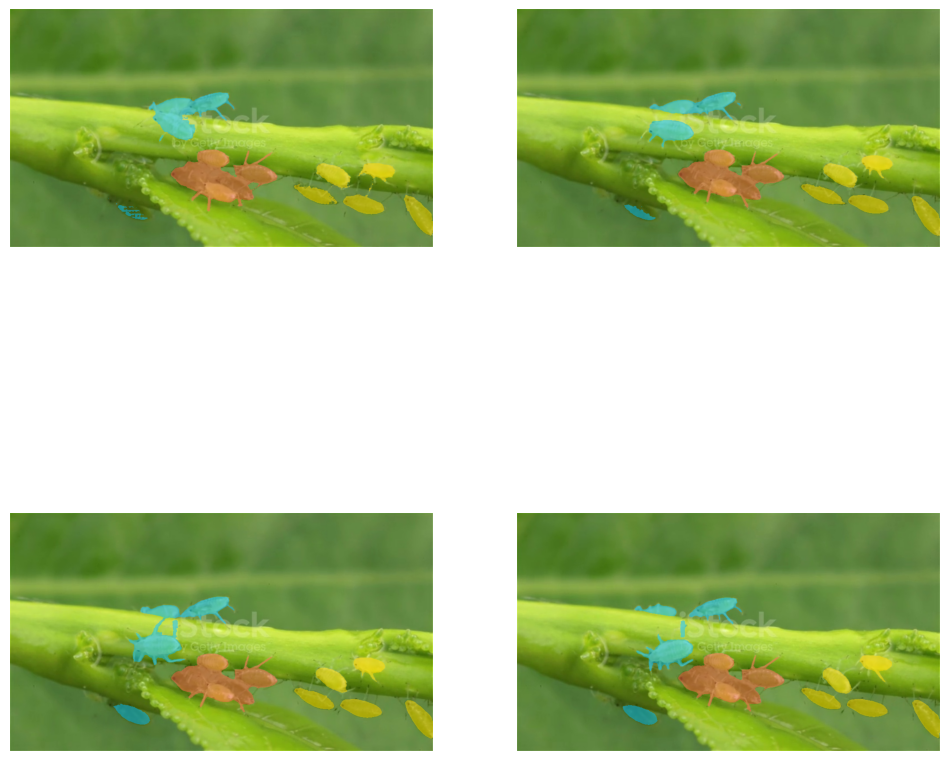

In [ ]:
sv.plot_images_grid(
    images=frame_sample[:4],
    grid_size=(2, 2)
)